In [11]:
import sys
from pathlib import Path

# Get project root
project_root = Path.cwd().parent

# Add to Python path
sys.path.insert(0, str(project_root))


In [12]:
from torch.utils.data import DataLoader
from pathlib import Path
from src.data.dataset import ISICSkinDataset
from src.data.transforms import train_transforms, val_transforms

project_root = Path.cwd().parent

train_dataset = ISICSkinDataset(
    csv_file=project_root / "data/processed/train/train_binary.csv",
    image_dir=project_root / "data/raw/train/images_train",
    transform=train_transforms
)

val_dataset = ISICSkinDataset(
    csv_file=project_root / "data/processed/val/val_binary.csv",
    image_dir=project_root / "data/raw/val/images_val",
    transform=val_transforms
)

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=0
)


In [13]:
images, labels = next(iter(train_loader))

print(images.shape)   # expected: (32, 3, 224, 224)
print(labels.shape)   # expected: (32,)
print(labels[:5])     # sanity check labels

torch.Size([8, 3, 224, 224])
torch.Size([8])
tensor([0, 0, 1, 1, 0])


In [14]:
from torch.utils.data import DataLoader

debug_loader = DataLoader(
    train_dataset,
    batch_size=5,
    shuffle=False,   # IMPORTANT for verification
    num_workers=0
)


In [15]:
images, labels = next(iter(debug_loader))


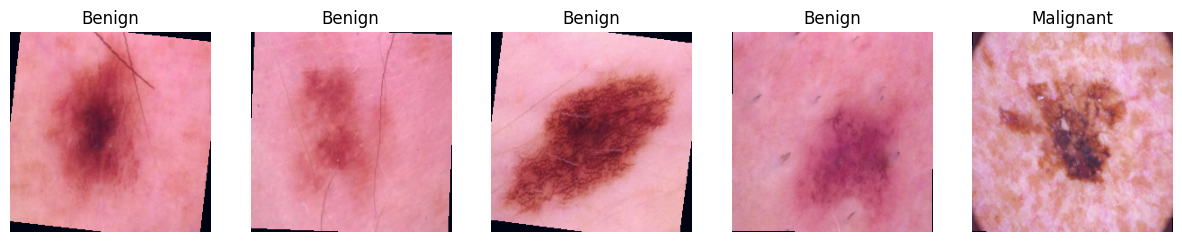

In [16]:
import matplotlib.pyplot as plt
import numpy as np

label_map = {0: "Benign", 1: "Malignant"}

plt.figure(figsize=(15, 4))

for i in range(len(images)):
    img = images[i].permute(1, 2, 0).numpy()   # CHW → HWC
    img = (img - img.min()) / (img.max() - img.min())  # normalize for display

    plt.subplot(1, len(images), i + 1)
    plt.imshow(img)
    plt.title(label_map[int(labels[i])])
    plt.axis("off")

plt.show()


ResNet-50 Setup (Model)

In [3]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)

# Replace final layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\LENOVO/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100.0%


In [4]:
# Replace final layer (1000 → 2)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# Move to device
model = model.to(device)

print(model.fc)

Linear(in_features=2048, out_features=2, bias=True)


In [10]:
images, labels = next(iter(train_loader))

images = images.to(device)
labels = labels.to(device)

outputs = model(images)

print("Output shape:", outputs.shape)
print("Sample logits:", outputs[:2])


Output shape: torch.Size([8, 2])
Sample logits: tensor([[-0.1106, -0.1899],
        [-0.0628, -0.0618]], grad_fn=<SliceBackward0>)
